In [1]:
from utils_data_prep import *
import glob
import os
import geopandas as gpd

import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import numpy as np

# KyFromAbove Tile Index

* The KyFromAbove 5K tile index contains three polygon feature classes for downloading the DEM, Aerial Imagery, and LiDAR point cloud datasets. Each feature class has attributes including the available datasets for each tile (some tiles have had lidar and/or imagery collected over multiple years) and data download links.

    * Note: The KyFromAbove aerial imagery is three bands (RGB), and the fourth infrared band dataset must be downloaded from the REST API without the tile index.

* The code below...
    1. The tile index is downloaded and each of the three feature class layers are read and saved as GeoJSON files. 
    2. GeoJSON tile index files are then used to extract only the relevant tiles that cover the Warren or Hardin County areas.

In [11]:
################################
# kentucky index tile dataset
################################

# download path for tile index geodatabase zip file
download_path = r'../data/KyFromAbove_Data_Product_Tile_Grids.gdb.zip'


###### get tile index files or handle existing
if len(glob.glob(r'../data/*.geojson')) > 0:
    for file in glob.glob(r'../data/*.geojson'):
        print(f"File - {file} - already exists...")
else:
    # custom function to download tile index, read geodatabase, and save feature classes as geojsons
    get_tile_index(download_path)

# delete point cloud index file
for file in glob.glob(r'../data/*.geojson'):
    if 'pointcloud' in file.lower():
        os.remove(file)

## *Warren County*

In [5]:
###########################################################
# Warren County dataset boundary & buffered boundary
###########################################################

# path to geodatabase containing boundary feature class
gdb_path = r'../data/geology.gdb'

# layer name of boundary feature class
boundary_layer = r'warren_geo_boundary'

# path to save output as GeoJSON
boundary_output_path = r'../data/warren/boundary.geojson'

# set buffer distance in spatial units of feature class (feet in this case)
# buffer distance should be enough to mitigate edge effects of any DEM derivative terrain feature calculations
buffer_distance = 1000

# path to save buffered output as GeoJSON
buffered_output_path = f"../data/warren/boundary_buffer{buffer_distance}.geojson"


##### create boundary GeoJSON if it doesn't exist
if os.path.isfile(boundary_output_path):
    print(f"File - {boundary_output_path} - already exists")
else:
    gdf = gpd.read_file(gdb_path, layer=boundary_layer)
    gdf.to_file(boundary_output_path, driver='GeoJSON')


##### create buffered boundary GeoJSON if it doesn't exist
if os.path.isfile(buffered_output_path):
    print(f"File - {buffered_output_path} - already exists")
else:
    gdf = gpd.read_file(gdb_path, layer=boundary_layer)
    gdf['geometry'] = gdf['geometry'].buffer(buffer_distance)
    gdf.to_file(buffered_output_path, driver='GeoJSON')

In [10]:
##############################################
# extract tiles that intersect warren county
##############################################

# list of tile index geojson file paths
index_paths = glob.glob(r'../data/*.geojson')

# path to labeled dataset boundary file (use buffered boundary)
boundary_path = glob.glob(r'../data/warren/boundary_buffer*.geojson')[0]


###### iterate through each index (should be dem & aerial)
for path in index_paths:

    # get filename of index
    filename = os.path.basename(path) 
    
    # create output path
    output_path = f"../data/warren/warren_{filename}"

    if os.path.isfile(output_path):
        print(f"File - {output_path} - already exists...")
    else:
        # custom function to get tiles intersecting boundary and save as output geojson
        get_intersecting_index_tiles(path, boundary_path, output_path)

File - ../data/warren/warren_KYAPED_Aerial_Tile_Index.geojson - already exists...
File - ../data/warren/warren_KYAPED_5FT_DEM_Tile_Index.geojson - already exists...


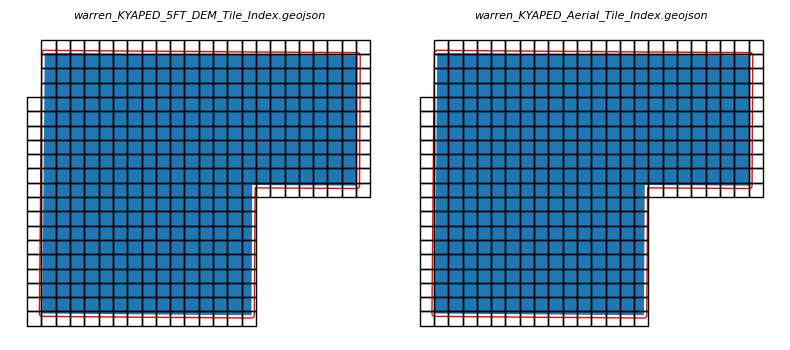

In [13]:
###############################################
# visualize coverage of index tiles and datasets
###############################################

# boundary path
boundary_path = r'../data/warren/boundary.geojson'

# buffered boundary path
buffered_path = glob.glob(r'../data/warren/boundary_buffer*.geojson')[0]

# get list of index geojsons for warren county (excluding buffered boundary geojson)
index_paths = [file for file in glob.glob(r'../data/warren/*.geojson') if not 'boundary' in file]


###### plot boundaries and index tiles...
fig, ax = plt.subplots(ncols=2, figsize=(8,8))

# read boundares as geodataframes
boundary = gpd.read_file(boundary_path)
buffered = gpd.read_file(buffered_path)

# iterate through list of geojson index paths (dem & aerial)
for idx, path in enumerate(index_paths):
    index = gpd.read_file(path)
    boundary.plot(ax=ax[idx])
    buffered.plot(ax=ax[idx], edgecolor='red', facecolor='none')
    index.plot(ax=ax[idx], edgecolor='k', facecolor='none')
    ax[idx].set_title(os.path.basename(path), style='italic', fontsize=8)
    ax[idx].set_axis_off()
plt.tight_layout()
plt.show()

## *Hardin County*

# DEM

* The Kentucky statewide digital elevation model (DEM) is derived from airborne lidar collected since 2010. The data collection prograrm has been divided into phases based on time and resolution, with Phase 1 resulting in a 5 foot resolution DEM, and a 2 foot resolution DEM for Phase 2. The data are publicly available as downloads of small tiles in either .img (with associated metadata files) or .tif (GeoTIFF).

* The code below...
    1. The tile index grids are used to download the relevant individual .tif files for the 5 foot DEM (Phase 1) in the Warren and Hardin County datasets.
    2. Individual DEM tiles are then mosaiced into a single DEM for each area and saved as a new GeoTIFF.
    3. The single DEMs for each area are finally clipped to the project area extents of Warren and Hardin Counties. 

## *Warren County*

In [2]:
###############################################
# download DEM tiles (.tif) for Warren County
###############################################

# path to geojson dem tile index
index_path = r'../data/warren/warren_KYAPED_5FT_DEM_Tile_Index.geojson'

# field containing unique tile id for file naming
id_field = 'TileName'

# field containing geotiff download url
url_field = 'Phase1_AWS_url'

# output directory to save downloaded tiles
output_dir = r'../data/warren/dem_tiles'


###### call custom function to download tiles
download_data_tiles(index_path, id_field, url_field, output_dir)

In [3]:
#############################################
# Mosaic DEM tiles into single DEM GeoTIFF
#############################################

# path to buffered boundary geojson file
boundary_path = glob.glob(r'../data/warren/boundary_buffer*.geojson')[0]

# path to geojson containing tile polygons
index_path = r'../data/warren/warren_KYAPED_5FT_DEM_Tile_Index.geojson'

# directory containing dem tiles
dem_tile_dir = r'../data/warren/dem_tiles'

# path for output dem
output_dem_path = r'../data/warren/dem.tif'


##### get lists of paths of edge tiles & contained tiles
within_tile_paths, edge_tile_paths = get_contained_and_edge_tile_paths(index_path, boundary_path, dem_tile_dir)


##### iterate through edge tiles and clip to dataset boundary
for tile_path in edge_tile_paths:
    clip_image_to_boundary(tile_path, boundary_path, output_tif_path=None)


##### get list of clipped edge tile paths & combine with contained tile paths
clipped_edge_tile_paths = glob.glob(f"{dem_tile_dir}/*clip.tif")
tile_paths_list = within_tile_paths + clipped_edge_tile_paths


##### mosaic clipped edge and contained tiles into single dem and save
mosaic_image_tiles(tile_paths_list, output_dem_path)


##### clean up clipped tiles (keep original full tiles)
for path in clipped_edge_tile_paths:
    os.remove(path)

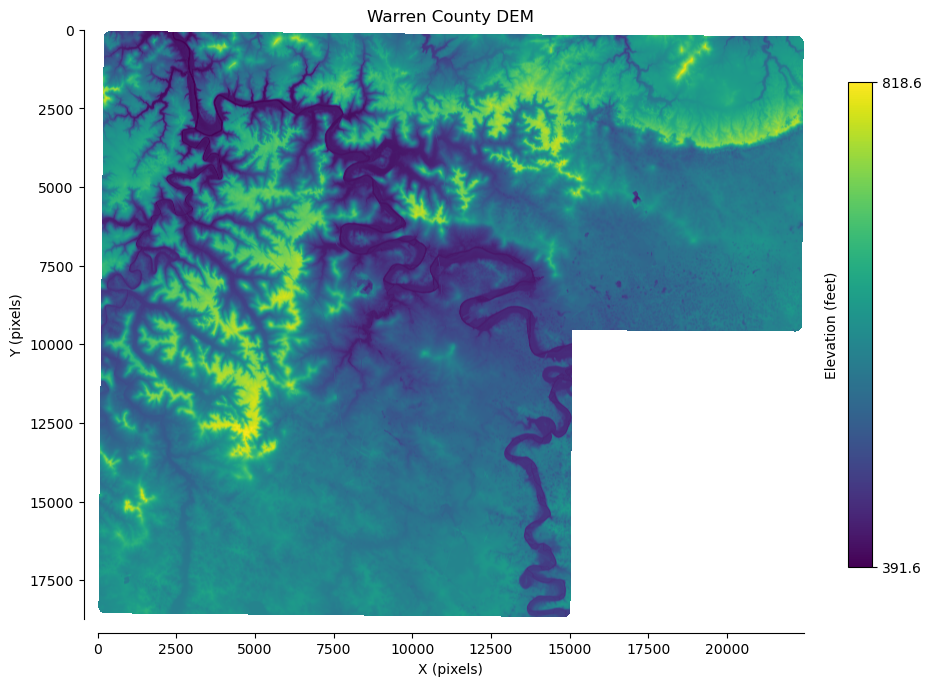

In [4]:
##########################
# visualize clipped dem
##########################

dem_path = r'../data/warren/dem.tif'

fig, ax = plt.subplots(figsize=(10,10))

with rasterio.open(dem_path) as src:
    data = src.read(1, masked=True)
    min_val = np.min(data)
    max_val = np.max(data)
    dem = ax.imshow(data, cmap='viridis', interpolation='bicubic')
    src.close()

cbar = fig.colorbar(dem, ax=ax, orientation='vertical', shrink=0.5)
cbar.set_ticks([min_val, max_val])
cbar.set_label('Elevation (feet)', labelpad=-70)

ax.set_title('Warren County DEM')
ax.set_xlabel('X (pixels)')
ax.set_ylabel('Y (pixels)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_position(('outward', 10))  # offset bottom axis
ax.spines['left'].set_position(('outward', 10))    # offset left axis
    
plt.tight_layout()
plt.show()

# ax.set_axis_off()
# plt.savefig(r'../data/warren/dem.png', bbox_inches='tight', pad_inches=0, transparent=True)

## *Hardin County*

# Aerial Imagery

* Aerial imagery has been collected simultaneously with lidar through the KyFromAbove program with resolutions between 1 foot to 3 inches, and complete statewide coverage of 6 inches. Imagery was collected for true color imagery with three bands (RGB), but near infrared has been captured as a fourth band in some areas; however, only true color imagery is available for download.

* The code below...
    1. The tile index grids are used to download individual aerial imagery tiles.
    2. Individual tiles are mosaiced together and then saved as a single GeoTIFF image.
    3. The single aerial imagery files are then clipped to the boundaries of the Warren and Hardin Counties datasets.

## *Warren County*

In [5]:
#########################################################
# download aerial imagery tiles (.img) for Warren County
#########################################################

# path to geojson aerial imagery tile index
index_path = r'../data/warren/warren_KYAPED_Aerial_Tile_Index.geojson'

# field containing unique tile id for file naming
id_field = 'TileName'

# field containing geotiff download url (only available column for image downloads, 6 inch resolution)
url_field = 'Boxzip2021'

# output directory to save downloaded tiles
output_dir = r'../data/warren/aerial_tiles'

# call custom function to download tiles
download_data_tiles(index_path, id_field, url_field, output_dir)

In [5]:
with rasterio.open(r'/Users/matthew/GitHub/cs612/data/warren/dem.tif') as src:
    print(src.res)

(5.0, 5.0)


In [3]:
from rasterio.merge import merge
from rasterio.warp import calculate_default_transform, reproject, Resampling



def process_and_resample(input_files, reference_file, output_file, band):
    """
    Mosaic input files, convert to float32, update nodata to NaN,
    clip to reference bounds, and resample to match the reference file, all in one pass for a specific band.
    """
    # Get reference image metadata
    with rasterio.open(reference_file) as ref:
        dst_crs = ref.crs
        dst_transform = ref.transform
        dst_width = ref.width
        dst_height = ref.height
        dst_res = ref.res
        dst_dtype = ref.dtypes[0]
        dst_nodata = ref.nodata
        dst_bounds = ref.bounds

    # Prepare output metadata
    src_files_to_mosaic = [rasterio.open(fp) for fp in input_files]
    src = src_files_to_mosaic[0]
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": dst_height,
        "width": dst_width,
        'res': dst_res,
        "transform": dst_transform,
        "crs": dst_crs,
        "dtype": dst_dtype,
        "nodata": dst_nodata,
        "count": 1
    })

    # Mosaic and resample the tiles
    mosaic, mosaic_transform = merge(src_files_to_mosaic, indexes=[band], res=dst_res, resampling=Resampling.bilinear)
    mosaic = mosaic.astype(dst_dtype)
    mosaic[mosaic == src.nodata] = dst_nodata

    # Clip the mosaic to the reference bounds
    within_tile_paths, edge_tile_paths = get_contained_and_edge_tile_paths(index_path, boundary_path, aerial_tile_dir, file_suffix='_f32.tif')
    for tile_path in edge_tile_paths:
        clip_image_to_boundary(tile_path, boundary_path, output_tif_path=None)
    clipped_edge_tile_paths = glob.glob(f"{aerial_tile_dir}/*clip.tif")
    tile_paths_list = within_tile_paths + clipped_edge_tile_paths
    

    

    # Process and write
    with rasterio.open(output_file, "w", **out_meta) as dest:
        reproject(
            source=mosaic,
            destination=rasterio.band(dest, 1),
            src_transform=mosaic_transform,
            src_crs=src.crs,
            dst_transform=dst_transform,
            dst_crs=dst_crs,
            resampling=Resampling.bilinear
        )

    # Close all input files
    for src in src_files_to_mosaic:
        src.close()

def main():
    input_files = glob.glob("path/to/input/*.tif")
    reference_file = "path/to/reference.tif"
    output_dir = "path/to/output/"
    
    os.makedirs(output_dir, exist_ok=True)
    
    # Step 1: Mosaic, convert dtype, update nodata, and resample
    processed_file = os.path.join(output_dir, "processed_mosaic.tif")
    process_and_resample(input_files, reference_file, processed_file)
    
    # Step 2: Split bands
    output_prefix = os.path.join(output_dir, "final")
    split_bands(processed_file, output_prefix)


In [4]:
tile_paths = glob.glob(r'../data/warren/aerial_tiles/*.tif')

reference_path = r'../data/warren/dem.tif'

output_path = r'../data/warren/aerial.tif'

process_and_resample(tile_paths, reference_path, output_path, band=1)


: 

In [ ]:
#########################
# Convert RGB+IR dtypes
#########################

# paths for aerial tiles
aerial_tile_paths = glob.glob(r'../data/warren/aerial_tiles/*.tif')

# custom function for converting aerial image tiles to float32 with nan for nodata
for path in aerial_tile_paths:
    convert_image_dtype(path, 'float32')

In [ ]:
############################################################
# Mosaic aerial imagery tiles into single channel GeoTIFFs
############################################################

# path to geojson containing tile polygons
index_path = r'../data/warren/warren_KYAPED_Aerial_Tile_Index.geojson'

# path to buffered boundary geojson file
boundary_path = glob.glob(r'../data/warren/boundary_buffer*.geojson')[0]

# directory containing aerial tiles
aerial_tile_dir = r'../data/warren/aerial_tiles'


# get lists of paths of edge tiles & contained tiles
within_tile_paths, edge_tile_paths = get_contained_and_edge_tile_paths(index_path, boundary_path, aerial_tile_dir, file_suffix='_f32.tif')


# iterate through edge tiles and clip to dataset boundary
for tile_path in edge_tile_paths:
    clip_image_to_boundary(tile_path, boundary_path, output_tif_path=None)


# get list of clipped edge tile paths & combine with contained tile paths
clipped_edge_tile_paths = glob.glob(f"{aerial_tile_dir}/*clip.tif")
tile_paths_list = within_tile_paths + clipped_edge_tile_paths


# iterate through bands and mosaic clipped edge and contained tiles into single image and save...
band_names = ['red', 'green', 'blue', 'ir']
for i, band in enumerate(band_names, start=1):
    output_aerial_path = f"../data/warren/aerial_{band}_5ft.tif"
    mosaic_image_tiles(tile_paths_list, output_aerial_path, band_number=i, resample=(5,5))


# clean up clipped tiles (keep original tiles)
for path in clipped_edge_tile_paths:
    os.remove(path)

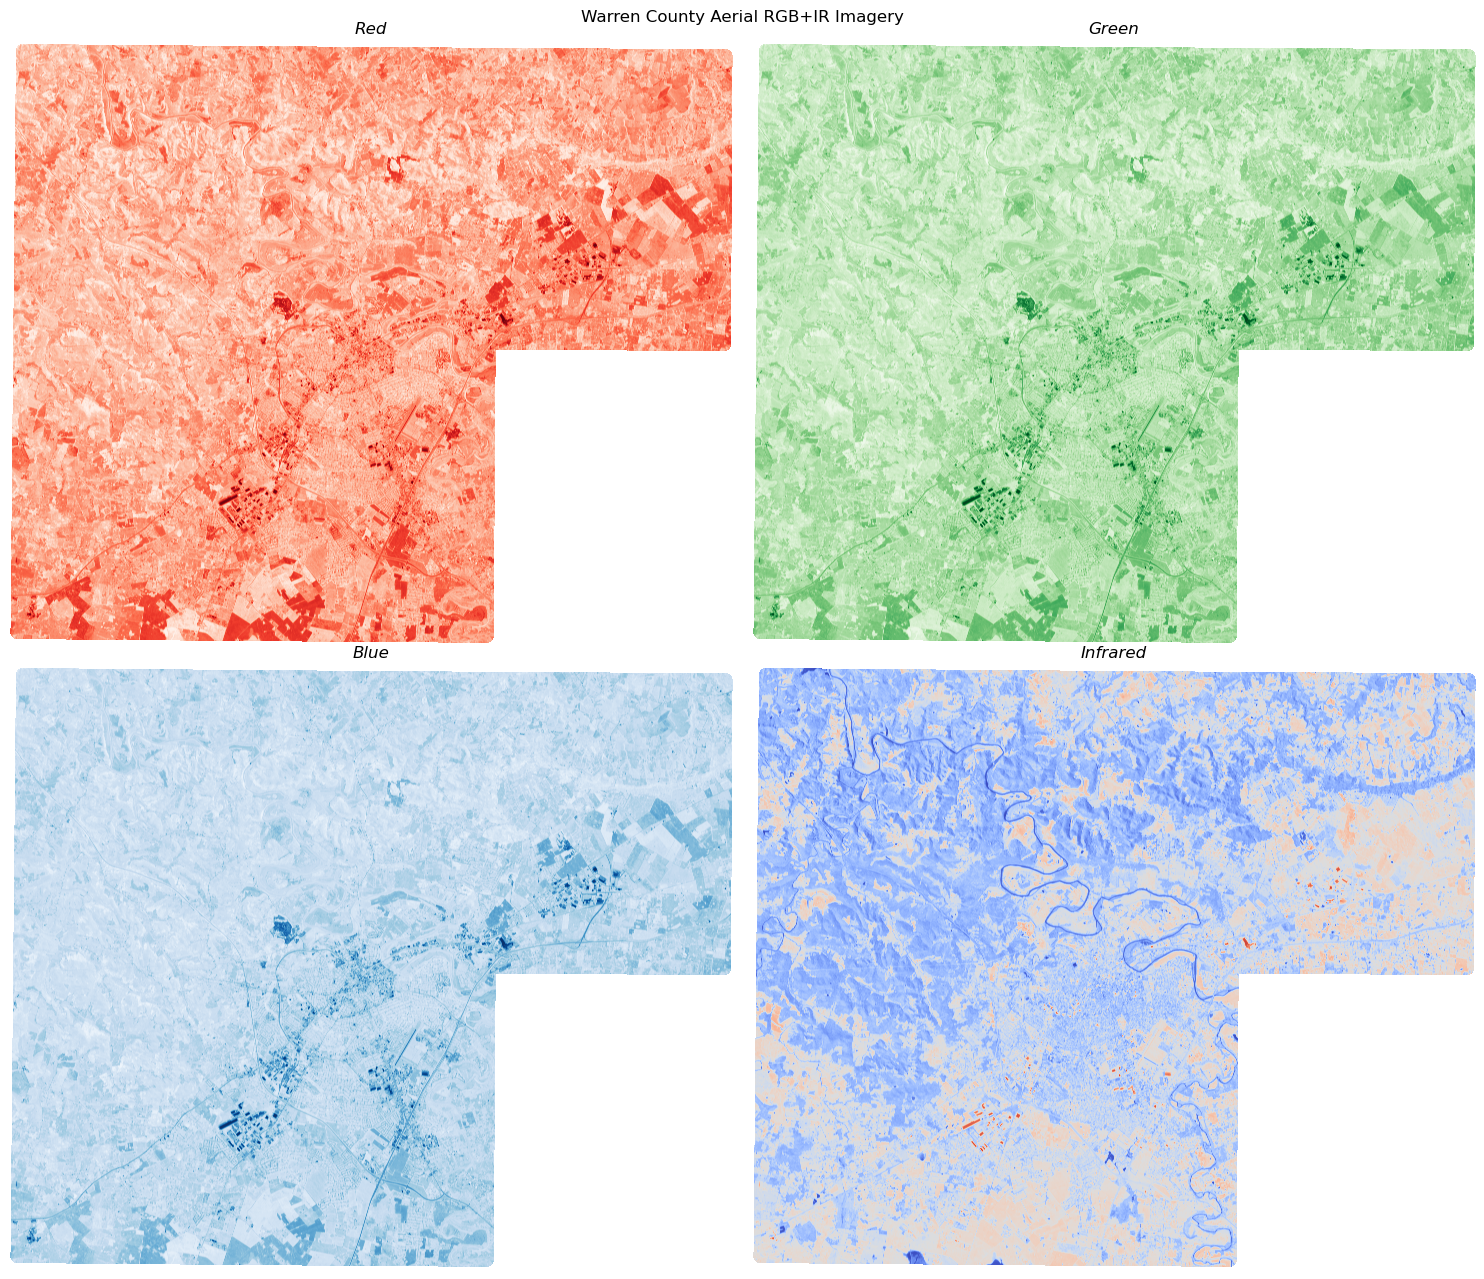

In [4]:
####################################
# Visualize clipped aerial images
####################################

# paths to single band aerial images
red_path = r'../data/warren/aerial_red_5ft.tif'
green_path = r'../data/warren/aerial_green_5ft.tif'
blue_path = r'../data/warren/aerial_blue_5ft.tif'
ir_path = r'../data/warren/aerial_ir_5ft.tif'
aerial_paths = [red_path, green_path, blue_path, ir_path]

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,13))
ax = ax.ravel()

for idx, path in enumerate(zip(aerial_paths, ['Reds', 'Greens', 'Blues', 'coolwarm'])):
    with rasterio.open(path[0]) as src:
        data = src.read(1)
        ax[idx].imshow(data, cmap=path[1], interpolation='bicubic')
        ax[idx].set_title(['Red', 'Green', 'Blue', 'Infrared'][idx], style='italic')
        ax[idx].set_axis_off()
        src.close()

        # fig, ax = plt.subplots(figsize=(10,10))
        # ax.imshow(data, cmap=path[1], interpolation='bicubic')
        # ax.set_axis_off()
        # img_name = ['Red', 'Green', 'Blue', 'Infrared'][idx]
        # plt.savefig(f"../data/warren/aerial_{img_name}_5ft.png", bbox_inches='tight', pad_inches=0, transparent=True)

plt.suptitle('Warren County Aerial RGB+IR Imagery')
plt.tight_layout()
plt.show()

## Hardin County

# Hydrography

The NHDPlus HR is a geospatial dataset depicting the flow of water across the Nation's landscapes and through the stream network. The NHDPlus HR was built using the National Hydrography Dataset High Resolution data at 1:24,000 scale or more detailed, the 10 meter 3D Elevation Program data, and the nationally complete Watershed Boundary Dataset. For more details, see: https://pubs.usgs.gov/publication/ofr20191096.

## Warren County

In [3]:
################################################
# Download NHDPlus HR Dataset for Warren County
################################################

# url for HUC 4 Basin 0511 (covers Warren County area)
nhd_url = r'https://prd-tnm.s3.amazonaws.com/StagedProducts/Hydrography/NHDPlusHR/VPU/Current/GDB/NHDPLUS_H_0511_HU4_GDB.zip'

# directory to save hydrography
nhd_dir = r'../data/warren/nhdplushr'
if not os.path.isdir(nhd_dir):
    os.makedirs(nhd_dir)

# path to save NHDPlus HR geodatabase
nhd_output_path = r'../data/warren/nhdplushr/nhd.zip'

# custom function to download zip, extract contents, and delete zip
download_zip(nhd_url, nhd_output_path)

In [4]:
###################################################################
# Clip to Flowline & Waterbody feature classes to Dataset Boundary
###################################################################

# path to NHDPlus HR geodatabase
nhd_gdb_path = glob.glob(r'../data/warren/nhdplushr/*.gdb')[0]

# path to dataset boundary GeoJSON
boundary_path = glob.glob(r'../data/warren/*boundary*.geojson')[0]

# iterate through specified layers in geodatabase and clip to dataset boundary
# (NHDFlowline & NHDWaterbody in Hydrography feature classes for this project)
for gdb_layer in ['NHDFlowline', 'NHDWaterbody']:
    output_path = f"../data/warren/nhdplushr/{gdb_layer}.geojson"
    if not os.path.isfile(output_path):
        clip_spatial_to_boundary(nhd_gdb_path, boundary_path, output_path, gdb_layer)

# delete geodatabase after clipping to dataset boundary
shutil.rmtree(nhd_gdb_path)

In [3]:
# from rasterio.features import rasterize


# def convert_spatial_to_reference_image(input_spatial, reference_image, output_path, attribute=None):
#     """
#     Function to convert geospatial vector files (shapefile or GeoJSON) to images with spatial, resolution, and transform properties of a reference image (GeoTIFF).

#     Parameter
#     ---------
#     input_spatial : string
#         Path to geospatial file.
#     reference_image : string
#         Path to reference GeoTIFF image.
#     output_path : string
#         Path for output image.
#     attribute : string (optional)
#         Name of geospatial attribute to categorize image values. Default is None, which categorizes output image as binary (1 for spatial features, 0 for background),

#     Returns
#     -------
#     None
#     """

#     gdf = gpd.read_file(input_spatial)

#     with rasterio.open(reference_image) as src:

#         if gdf.crs != src.crs:
#             gdf = gdf.to_crs(src.crs)
        

#         if not attribute:
#             shapes = [(geom, 1) for geom in gdf.geometry]
#         else:
#             shapes = [(geom, value) for geom, value in zip(gdf.geometry, gdf[attribute])]
            
#         output_image = rasterize(shapes=shapes, 
#                                  out_shape=(src.height, src.width), 
#                                  transform=src.transform, 
#                                  fill=0, 
#                                  all_touched=True, 
#                                  dtype=rasterio.float32)
        
#         mask = src.dataset_mask()
#         output_image = np.where(mask, output_image, src.nodata)

#         output_meta = src.meta.copy()
#         output_meta.update({'driver': 'GTiff', 
#                             'count': 1, 
#                             'dtype':rasterio.float32})
        
#         with rasterio.open(output_path, 'w', **output_meta) as dst:
#             dst.write(output_image.astype(rasterio.float32), 1)

In [4]:
####################
# Convert to Images
####################

nhd_gis_files = glob.glob(r'../data/warren/nhdplushr/*.geojson')
reference_image = r'../data/warren/dem.tif'

for nhd_path in nhd_gis_files:
    output_filename = os.path.basename(nhd_path)
    output_filename = os.path.splitext(output_filename)[0]
    output_path = f"../data/warren/{output_filename}.tif"
    convert_spatial_to_reference_image(nhd_path, reference_image, output_path, attribute=None)


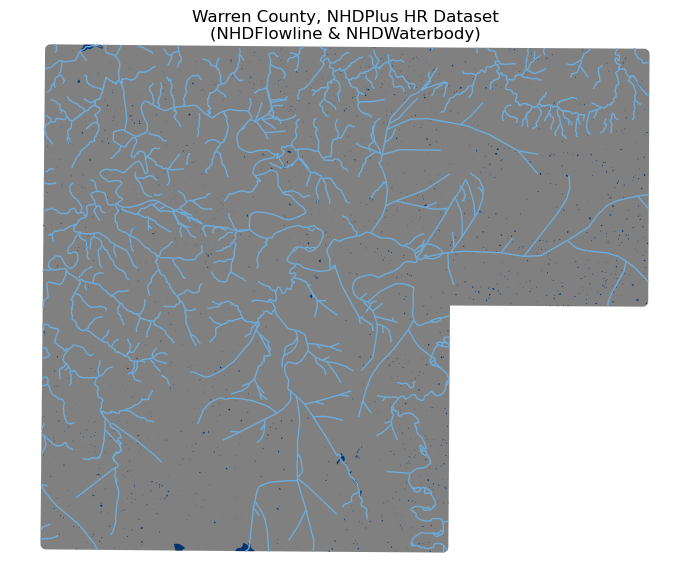

In [5]:
#######################################
# Visualize Flowline & Waterbody (GIS) 
#######################################

fig, ax = plt.subplots(figsize=(7, 7))

gdf_flowline = gpd.read_file(r'../data/warren/nhdplushr/NHDFlowline.geojson')
gdf_waterbody = gpd.read_file(r'../data/warren/nhdplushr/NHDWaterbody.geojson')
gdf_boundary = gpd.read_file(glob.glob(r'../data/warren/*boundary*.geojson')[0])

gdf_boundary.plot(ax=ax, color='grey')
gdf_flowline.plot(ax=ax, color='#6EACDA', linewidth=1)
gdf_waterbody.plot(ax=ax, color='#03346E')

ax.set_axis_off()
ax.set_title('Warren County, NHDPlus HR Dataset\n(NHDFlowline & NHDWaterbody)', y=0.95)
plt.tight_layout()
plt.show()

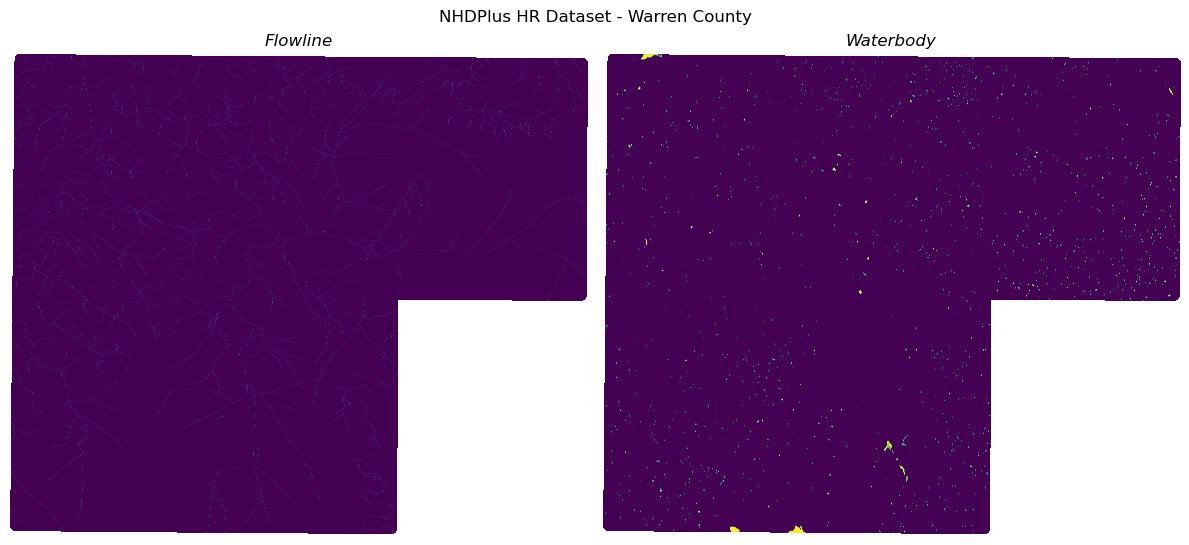

In [13]:
###########################################
# Visualize Flowline & Waterbody (Images) 
###########################################

flowline_path = r'../data/warren/NHDFlowline.tif'

waterbody_path = r'../data/warren/NHDWaterbody.tif'

fig, ax = plt.subplots(ncols=2, figsize=(12,6))

with rasterio.open(flowline_path, 'r') as flowline:
    show(flowline, ax=ax[0])

with rasterio.open(waterbody_path, 'r') as waterbody:
    show(waterbody, ax=ax[1])

for axes in ax:
    axes.set_axis_off()
ax[0].set_title('Flowline', style='italic')
ax[1].set_title('Waterbody', style='italic')
plt.suptitle('NHDPlus HR Dataset - Warren County', y=0.95)
plt.tight_layout()
plt.show()

## Hardin County

In [ ]:
# url's for NHDPlusHR HUC4 Basins covering Hardin County

# nhd_north_url = r'https://prd-tnm.s3.amazonaws.com/StagedProducts/Hydrography/NHDPlusHR/VPU/Current/GDB/NHDPLUS_H_0514_HU4_GDB.zip'

# nhd_south_url = r'https://prd-tnm.s3.amazonaws.com/StagedProducts/Hydrography/NHDPlusHR/VPU/Current/GDB/NHDPLUS_H_0511_HU4_GDB.zip'

# Roads & Railroads

In [15]:
# URL for Open Street Maps Kentucky dataset download
osm_url = r'http://download.geofabrik.de/north-america/us/kentucky-latest-free.shp.zip'

# directory to save Open Street Maps dataset
osm_dir = r'../data/ky_osm'
if not os.path.isdir(osm_dir):
    os.makedirs(osm_dir)

# path to temporarily save downloaded zip file
osm_zip_path = r'../data/ky_osm/ky_osm.zip'

# custom function to download zip, extract contents, and delete zip
download_zip(osm_url, osm_zip_path)

# only save shapefiles for roads and railroads (gis_osm_roads_free_1 & gis_osm_railways_free_1)
all_shapefiles = glob.glob(os.path.join(osm_dir, '*.*'))
for path in all_shapefiles:
    if 'gis_osm_roads_free_1' in path:
        continue
    elif 'gis_osm_railways_free_1' in path:
        continue
    else:
        os.remove(path)

## Warren County

In [3]:
##########################################################
# Clip to Roads & Railways shapefiles to Dataset Boundary
##########################################################

# paths to directory containing road and railway shapefiles
osm_shp_paths = glob.glob(r'../data/ky_osm/*.shp')

# path to dataset boundary GeoJSON
boundary_path = glob.glob(r'../data/warren/*boundary*.geojson')[0]

# directory to store clipped osm datasets
osm_warren_dir = r'../data/warren/osm'
if not os.path.isdir(osm_warren_dir):
    os.makedirs(osm_warren_dir)

# iterate through shapefiles and clip to dataset boundary
for shp_path in osm_shp_paths:
    filename = os.path.basename(shp_path)
    filename = os.path.splitext(filename)[0]
    if 'roads' in filename:
        filename = 'OSM_Roads'
    else:
        filename = 'OSM_Railways'
    output_path = f"{osm_warren_dir}/{filename}.geojson"
    if not os.path.isfile(output_path):
        clip_spatial_to_boundary(shp_path, boundary_path, output_path)

In [5]:
####################
# Convert to Images
####################

osm_warren_files = glob.glob(r'../data/warren/osm/*.geojson')

reference_image = r'../data/warren/dem.tif'

for osm_path in osm_warren_files:
    output_filename = os.path.basename(osm_path)
    output_filename = os.path.splitext(output_filename)[0]
    output_path = f"../data/warren/{output_filename}.tif"
    convert_spatial_to_reference_image(osm_path, reference_image, output_path, attribute=None)

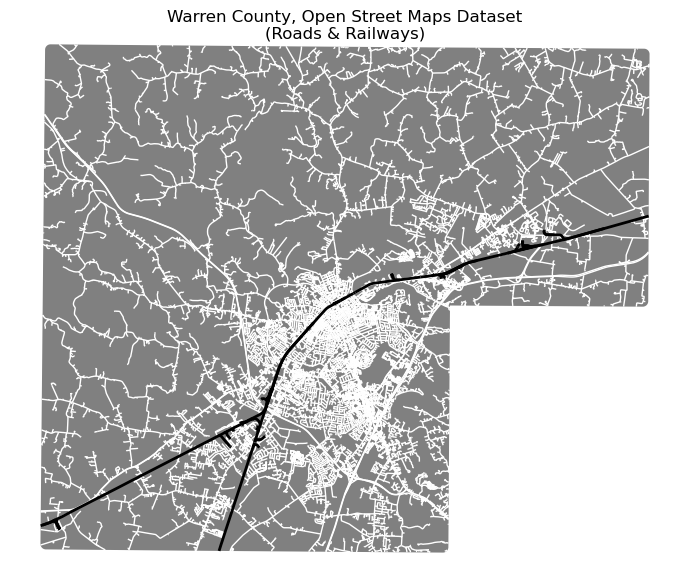

In [7]:
#######################################
# Visualize Roads & Railways (GIS) 
#######################################

fig, ax = plt.subplots(figsize=(7, 7))

gdf_roads = gpd.read_file(r'../data/warren/osm/OSM_Roads.geojson')
gdf_rails = gpd.read_file(r'../data/warren/osm/OSM_Railways.geojson')
gdf_boundary = gpd.read_file(glob.glob(r'../data/warren/*boundary*.geojson')[0])

gdf_boundary.plot(ax=ax, color='grey')
gdf_roads.plot(ax=ax, color='white', linewidth=1)
gdf_rails.plot(ax=ax, color='black', linewidth=2)

ax.set_axis_off()
ax.set_title('Warren County, Open Street Maps Dataset\n(Roads & Railways)', y=0.95)
plt.tight_layout()
plt.show()

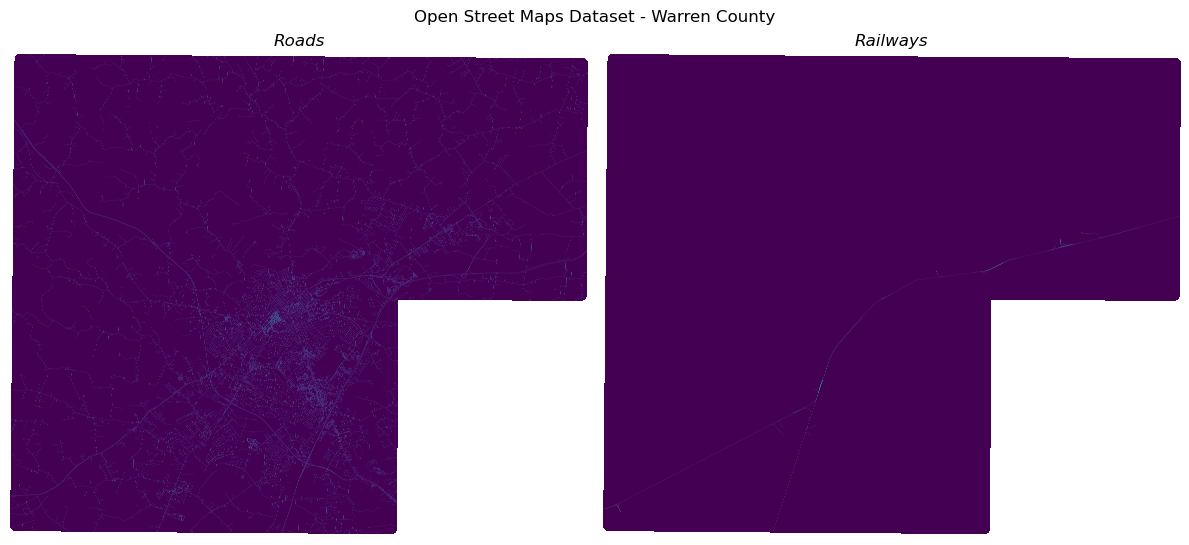

In [8]:
###########################################
# Visualize Roads & Railways (Images) 
###########################################

roads_path = r'../data/warren/OSM_Roads.tif'

rails_path = r'../data/warren/OSM_Railways.tif'

fig, ax = plt.subplots(ncols=2, figsize=(12,6))

with rasterio.open(roads_path, 'r') as roads:
    show(roads, ax=ax[0])

with rasterio.open(rails_path, 'r') as rails:
    show(rails, ax=ax[1])

for axes in ax:
    axes.set_axis_off()
ax[0].set_title('Roads', style='italic')
ax[1].set_title('Railways', style='italic')
plt.suptitle('Open Street Maps Dataset - Warren County', y=0.95)
plt.tight_layout()
plt.show()

## Hardin County

# Patches

## Warren County

In [19]:
from shapely.geometry import box

def create_patches(boundary_path, patch_size, overlap, image_resolution, output_path):

    gdf = gpd.read_file(boundary_path)

    patch_size_spatial_units = patch_size * image_resolution

    overlap_spatial_units = patch_size_spatial_units * (1-overlap)

    minx, miny, maxx, maxy = gdf.total_bounds

    patches = []

    x = minx
    while x < maxx:
        y = miny
        while y < maxy:
            patch = box(x, y, x+patch_size_spatial_units, y+patch_size_spatial_units)
            patches.append(patch)
            y += overlap_spatial_units
        x += overlap_spatial_units
    
    gdf_patches = gpd.GeoDataFrame(geometry=patches)
    gdf_patches['id'] = [f"{patch_size}_{i}" for i in range(1, len(gdf_patches)+1)]
    gdf_patches.to_file(output_path, driver='GeoJSON')


In [20]:
# path to warren county dataset boundary (not buffered boundary)
boundary_path = r'../data/warren/boundary.geojson'

# define patch size (in pixels)
patch_size = 256

# define overlap size (in proportion)
overlap = 0.5

# spatial resolution of reference image
image_resolution = 5

# output path of patches GeoJSON
output_path = f"../data/warren/patches_{patch_size}.geojson"


##### create patches and save as GeoJSON
create_patches(boundary_path, patch_size, overlap, image_resolution, output_path)


24912

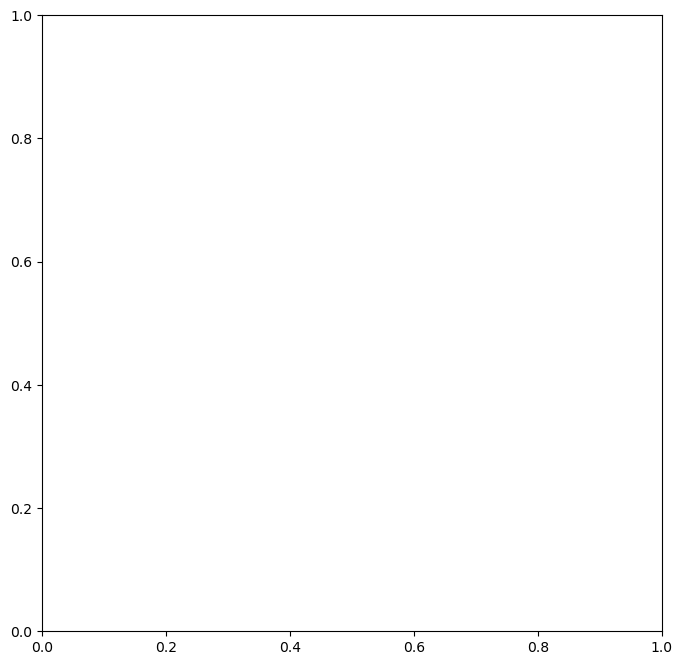

In [23]:
fig, ax = plt.subplots(figsize=(8,8))

gdf = gpd.read_file(r'../data/warren/patches_256.geojson')

# gdf.plot(ax=ax, edgecolor='k')

len(gdf)

## Hardin County

# Verify Image Alignment

In [10]:
# paths to images
image_paths = glob.glob(r'../data/warren/*.tif')
image_paths.sort()

for image in image_paths:
    with rasterio.open(image) as src:
        print('Name: ', os.path.basename(image))
        print('Spatial resolution: ', src.res)
        print('Width (pixels): ', src.meta['width'])
        print('Height (pixels): ', src.meta['height'])
        print(src.bounds)
        print('\n')


Name:  NHDFlowline.tif
Spatial resolution:  (5.0, 5.0)
Width (pixels):  22438
Height (pixels):  18723
BoundingBox(left=4664290.0, bottom=3477680.0, right=4776480.0, top=3571295.0)


Name:  NHDWaterbody.tif
Spatial resolution:  (5.0, 5.0)
Width (pixels):  22438
Height (pixels):  18723
BoundingBox(left=4664290.0, bottom=3477680.0, right=4776480.0, top=3571295.0)


Name:  OSM_Railways.tif
Spatial resolution:  (5.0, 5.0)
Width (pixels):  22438
Height (pixels):  18723
BoundingBox(left=4664290.0, bottom=3477680.0, right=4776480.0, top=3571295.0)


Name:  OSM_Roads.tif
Spatial resolution:  (5.0, 5.0)
Width (pixels):  22438
Height (pixels):  18723
BoundingBox(left=4664290.0, bottom=3477680.0, right=4776480.0, top=3571295.0)


Name:  dem.tif
Spatial resolution:  (5.0, 5.0)
Width (pixels):  22438
Height (pixels):  18723
BoundingBox(left=4664290.0, bottom=3477680.0, right=4776480.0, top=3571295.0)




# Scratch...

None
uint8
0
255


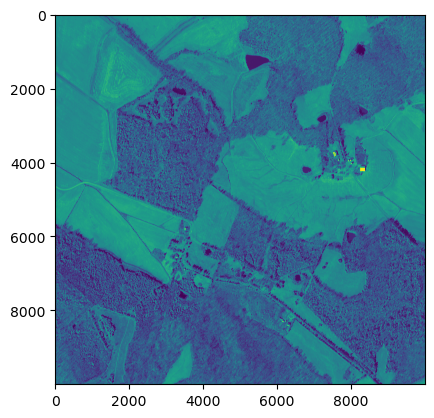

None
uint8
0
254


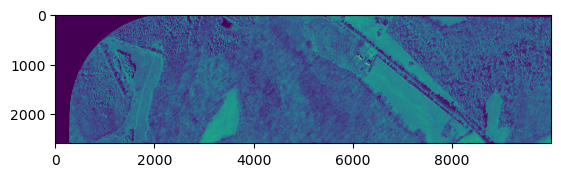

In [63]:
path = r'../data/warren/aerial_tiles/N158E178_2021.tif'

with rasterio.open(path) as src:
    data = src.read(4, masked=True)
    print(src.nodata)
    print(src.meta['dtype'])
    print(np.min(data))
    print(np.max(data))
    show(data)


clip_image_to_boundary(path, boundary_path, output_tif_path=r'../data/warren/test.tif')

with rasterio.open(r'../data/warren/test.tif') as src:
    data = src.read(4, masked=True)
    print(src.nodata)
    print(src.meta['dtype'])
    print(np.min(src.read(1)))
    print(np.max(src.read(1)))
    show(data)





-3.4028230607370965e+38
float32
391.61237
818.611


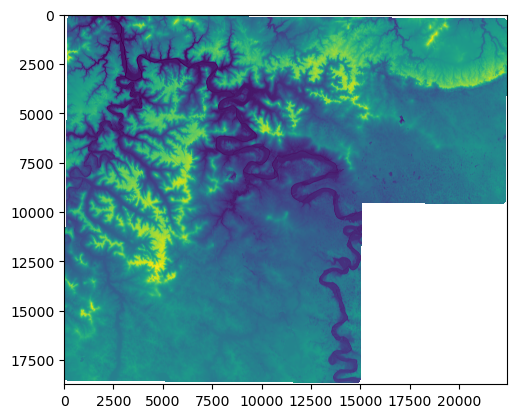

In [67]:
path = r'/Users/matthew/GitHub/cs612/data/warren/dem.tif'
# path = r'/Users/matthew/GitHub/cs612/data/warren/dem_tiles/N176E177.tif'
with rasterio.open(path) as src:
    print(src.nodata)
    print(src.meta['dtype'])
    data = src.read(1, masked=True)
    print(np.min(data))
    print(np.max(data))
    show(data)

In [2]:
output_aerial_path = r'../data/warren/aerial.tif'

fig, ax = plt.subplots()
with rasterio.open(output_aerial_path, tiled=True, blockxsize=1024, blockysize=1024) as src:
    show(src, ax=ax)

: 

In [8]:
# import glob
# import os
# aerial_tile_dir = r'../data/warren/aerial_tiles'

clipped_edge_tile_paths = glob.glob(f"{aerial_tile_dir}/*clip.tif")
clipped_edge_tile_paths
for path in clipped_edge_tile_paths:
    os.remove(path)

In [3]:
##################################################
# merge aerial imagery tiles into single geotiff
##################################################

# directory containing aerial imagery tiles
aerial_dir = r'../data/warren/aerial_tiles'

# output path for single mosaiced aerial image
output_aerial_path = r'../data/warren/aerial_mosaic.tif'

# custom function to mosaic aerial image tiles and save as new single image
mosaic_image_tiles(aerial_dir, output_aerial_path)

In [2]:
#########################################
# clip dem to warren county area extent
#########################################

# path to input mosaiced dem from above
input_im_path = r'../data/warren/aerial_mosaic.tif'

# path to geodatabase
gdb_path = r'../data/geology.gdb'

# layer name of boundary feature class in geodatabase used to clip dem 
boundary_layer = r'warren_geo_boundary'

# output path of new clipped dem
output_im_path = r'../data/warren/aerial.tif'

# call custom function to clip mosaiced dem to outline of labeled dataset boundary
clip_image_to_boundary(input_im_path, gdb_path, boundary_layer, output_im_path)

: 

In [ ]:
##########################
# visualize clipped dem
##########################

fig, ax = plt.subplots(figsize=(10,10))

with rasterio.open(output_dem_path) as src:
    data = src.read(1, masked=True)
    ax.imshow(data, cmap='viridis', interpolation='nearest')
    ax.set_title('Warren County DEM')
    ax.set_xlabel('X (pixels)')
    ax.set_ylabel('Y (pixels)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_position(('outward', 10))  # Offset bottom axis
    ax.spines['left'].set_position(('outward', 10))    # Offset left axis
    # fig.colorbar(dem, ax=ax, orientation='vertical')
    plt.tight_layout()
    plt.show()